# About Lingo3DMol

A fundamental problem in structure-based drug design is generating molecules that bind to specific protein binding sites. Recent advancements have seen the utilisation of deep generative models for this purpose. However, most methods are SMILES/strings-based or graph-based, which lack spatial information essential for understanding molecular interactions in three-dimensional space.


At molecular level, a molecule can be inhibited or activated through binding at the protein pockets. Hence, it is crucial to be aware of the geometrics when designing molecules.

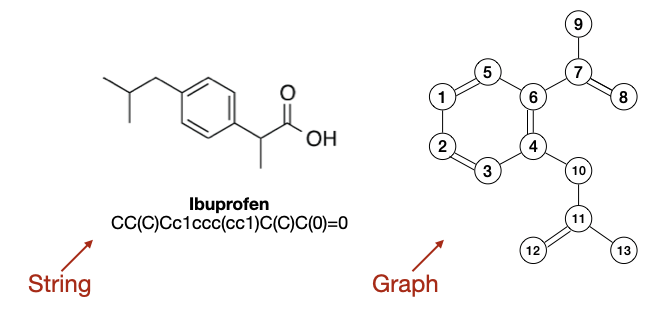

Lingo3DMol breaks free from the constraints of typical 2D representations, encoding both molecular bonds and atomic locations in 3D. This allows model to understand the spatial relationships within molecules. It uses a specific non-covalent interaction predictor to ensure that the created molecules fit into their respective pockets. Lingo3DMol also helps to avoid unwanted or impossible molecule formations.



**Solutions**:

1. Embedding 3D context directly into the language model.

2. Creates compounds that fit better by considering probable interactions within the pockets.

3. Prioritising drug-like features therefore reducing the synthesis of unrealistic molecules.

**Compare to other methods**:
* TargetDiff, avoids non-autoregressive generation, but produces unattractive structures.
* Graph-based approaches fail to replicate reference molecules without information leaking, which Lingo3DMol addresses.



# The Fragment-Based Simplified Molecular-Input Line Entry System (FSMILES)



*   Encodes ring size in all ring tokens to provide better context during molecule formation.
*   Ring-first traversal prioritizes ring creation, which results in more realistic topologies.


In [1]:
!pip install rdkit-pypi==2022.09.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 21.9 MB/s eta 0:00:00


In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, BRICS,AllChem
import re


## Read and writing the molecule

In [ ]:
# insdf = 'Conformer3D_COMPOUND_CID_56955953.sdf'
# suppl = Chem.SDMolSupplier(insdf)

In [ ]:
# mol = suppl[0]

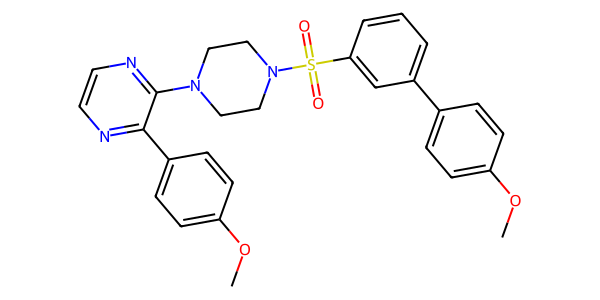

In [9]:
example = 'COc1ccc(-c2cccc(S(=O)(=O)N3CCN(c4nccnc4-c4ccc(OC)cc4)CC3)c2)cc1'
mol = Chem.MolFromSmiles(example)
img = Draw.MolToImage(mol, size=(600, 300))
display(img)


True


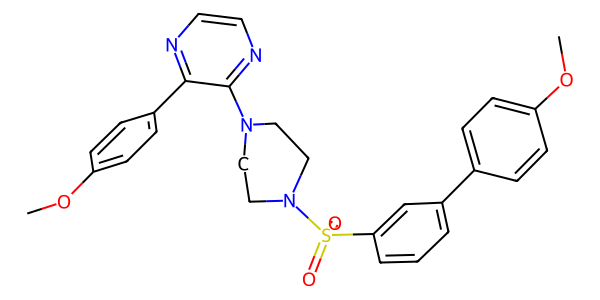

In [3]:
# example = 'COc1ccc(-c2cccc(S(=O)(=O)N3CCN(c4nccnc4-c4ccc(OC)cc4)CC3)c2)cc1'


# m = Chem.MolFromSmiles(example)
# mol = Chem.AddHs(m)

# AllChem.EmbedMolecule(mol)
# AllChem.UFFOptimizeMolecule(mol)

# print(mol.GetConformer().Is3D())
# mol = Chem.RemoveHs(mol)
# img = Draw.MolToImage(mol, size=(600, 300))

# # Display the image
# display(img)


## Step 1: Identify cuttable bonds and generate fragments

In [10]:
def find_cuttable_bonds(mol):
    """
    Find cuttable single bonds based on specific criteria.

    Parameters:
    - mol (rdkit.Chem.Mol)

    Yields:
    - tuple: A tuple representing the bond indices and labels of cuttable single bonds.
    """
    letter = re.compile('[a-z,A-Z]')
    bondsDone = set()

    for bond in mol.GetBonds():
        begin_atom, end_atom = bond.GetBeginAtom(), bond.GetEndAtom()

        # Check if the bond is not part of a ring
        is_not_in_ring = not bond.IsInRing()

        # Check if neither end of the bond is a hydrogen atom
        no_hydrogen_at_ends = all(atom.GetAtomicNum() != 1 for atom in (begin_atom, end_atom))

        # Check if at least one end of the bond is attached to a ring
        attached_to_ring = begin_atom.IsInRing() or end_atom.IsInRing()

        # If all conditions are met, the bond is considered cuttable
        if is_not_in_ring and no_hydrogen_at_ends and attached_to_ring:
            i1 = letter.sub('', str(begin_atom.GetIdx()))
            i2 = letter.sub('', str(end_atom.GetIdx()))
            bond_indices = (begin_atom.GetIdx(), end_atom.GetIdx())
            bond_labels = (i1, i2)

            if (bond_indices not in bondsDone) and ((bond_indices[1], bond_indices[0]) not in bondsDone):
                bondsDone.add(bond_indices)
                yield (bond_indices, bond_labels)


In [11]:
res = list(find_cuttable_bonds(mol))

In [12]:
m2 = BRICS.BreakBRICSBonds(mol,res)
Chem.MolToSmiles(m2).split(".")

['[1*]OC',
 '[11*]S([11*])(=O)=O',
 '[14*]N1CCN([17*])CC1',
 '[18*]c1nccnc1[23*]',
 '[2*]c1ccc([5*])cc1',
 '[24*]c1ccc([27*])cc1',
 '[28*]OC',
 '[6*]c1cccc([10*])c1']

## Step 2: Encode fragments with FSMILES token

In [13]:
def process_fragments(fragms, ring_info):
    processed_fragms = []

    counter = 0
    for fragm in fragms:

      match = re.search(r'\d+', fragm)

      if match:
          atom_idx = int(match.group())
          size = ring_info.AtomRingSizes(atom_idx)
          size = size[0] if size else 0
      else:
          print("No digit found in the string")
          size = 0

      new_fragm = re.sub(r'^\[\d+\*\]', '', fragm)  # remove '[*]' from the start of each fragment
      new_fragm = re.sub(r'\[(\d+)\*\]', r'[*]', new_fragm) # remove atom index from '[*]' at the connecting atom

      pattern = re.compile(r'\([^)]*\)|\[[^\]]*\]|[a-zA-Z]|[0-9]|[-+=#@]')
      result = pattern.findall(new_fragm)
      out = ''
      if counter == 0: # if the first fragment
        out += "'start_0'"
      for s in result:
          if s.isalpha():
              s += '_' + str(size)
          else:
              s += '_0'
          out += s

      out += "'sep_0'"
      counter+= 1
      if counter == len(fragms):
        out += "'end_0'"
        print(" ====== Finishing conversion ======" + '\n')

      processed_fragms.append(out)

    return ''.join(processed_fragms)

In [14]:
fragms = Chem.MolToSmiles(m2).split(".")
ring_info = m2.GetRingInfo()
process_fragments(fragms, ring_info)

 ====== Finishing conversion ======



"'start_0'O_0C_0'sep_0'S_0([*])_0(=O)_0=_0O_0'sep_0'N_61_0C_6C_6N_6([*])_0C_6C_61_0'sep_0'c_61_0n_6c_6c_6n_6c_61_0[*]_0'sep_0'c_61_0c_6c_6c_6([*])_0c_6c_61_0'sep_0'c_61_0c_6c_6c_6([*])_0c_6c_61_0'sep_0'O_0C_0'sep_0'c_61_0c_6c_6c_6c_6([*])_0c_61_0'sep_0''end_0'"